In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

import random
from data_bunch import *

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)

In [4]:
#export
def get_image_list(transforms):
    return ImageList.from_files(path, transforms=transforms)

## Flip

In [5]:
from torch.utils.data import DataLoader

transforms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
image_list_1 = get_image_list(transforms)
image_list_1.items = [image_list_1.items[0]] * 64
data_loader = DataLoader(image_list_1, 8)

In [6]:
#export
def show_image_sub(img, ax=None, figsize=(3, 3)):
    if ax == None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img.permute(1,2,0))
    
def show_image_batch(batch, c=4, r=None, figsize=None):
    bs = len(batch)
    r = r if r != None else int(math.ceil(bs/c))
    figsize = figsize if figsize != None else (c*3, r*3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for im, ax in zip(batch, axes.flat): 
        show_image_sub(im, ax)

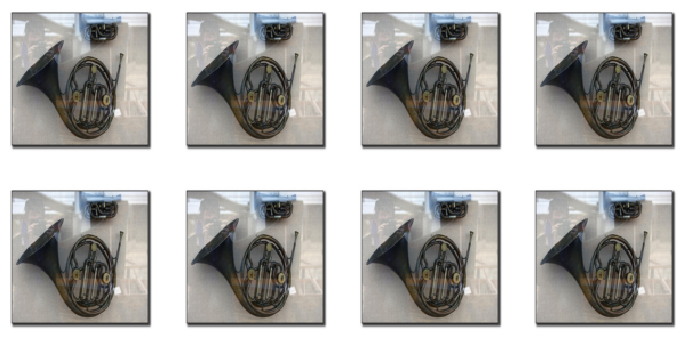

In [7]:
show_image_batch(next(iter(data_loader)))

In [8]:
#export
class PilTransform(Transform): 
    _order=11

class PilRandomFlipH(PilTransform):
    def __init__(self, p=0.5): 
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            return img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        return img

class PilRandomAllRotations(PilTransform):
    def __init__(self, p=0.75): 
        self.p = p * 7/8 
        
    def __call__(self, x):
         # transpose(n) has 8 options of rotation
        if random.random() > self.p: 
            return x
        return x.transpose(random.randint(0, 6))

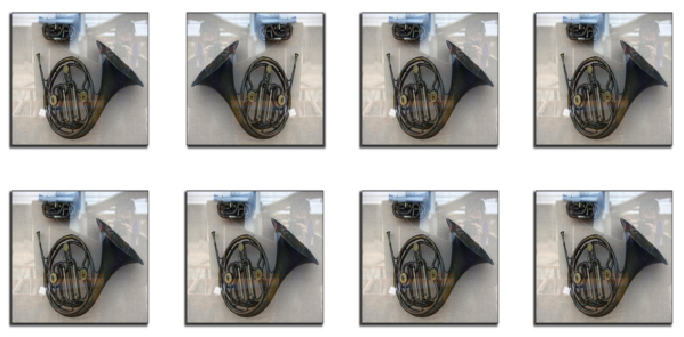

In [9]:
image_list_1.transforms.append(PilRandomFlipH())
show_image_batch(next(iter(data_loader)))

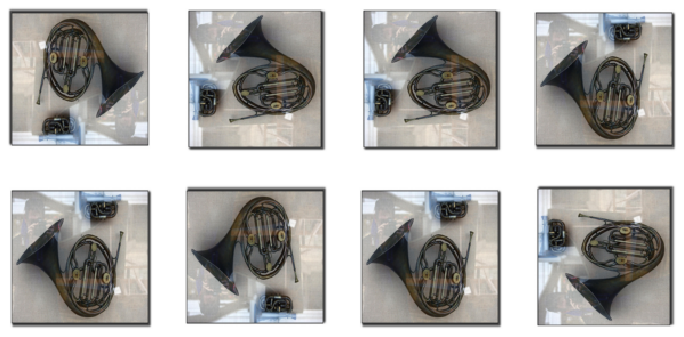

In [10]:
del image_list_1.transforms[-1]
image_list_1.transforms.append(PilRandomAllRotations())
show_image_batch(next(iter(data_loader)))

## Random Crop

In [11]:
#export
from random import randint

def process_size(size):
    if isinstance(size, (list, tuple)):
        assert(len(size) == 2)
        return tuple(size)
    else:
        return tuple([size, size])

def default_crop_size(w, h): 
    return [w, w] if w < h else [h, h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample = resample
        self.size = process_size(size)
        self.crop_size = None if crop_size == None else process_size(crop_size)
        
    def default_crop_size(self, w, h): 
        return default_crop_size(w, h)

    def __call__(self, img):
        crop_size = self.default_crop_size(*img.size) if self.crop_size == None else self.crop_size
        return img.transform(self.size, PIL.Image.EXTENT, self.get_corners(*img.size, *crop_size), resample=self.resample)
    
    def get_corners(self, w, h): 
        return (0, 0, w, h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): 
        return [w/self.scale, h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        self.ratio = ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w * h
        # usual technique for imagenet, try 10 times
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round((area * ratio) ** 0.5))
            new_h = int(round((area / ratio) ** 0.5))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # cropped
        r = w/h
        if r < self.ratio[0]: 
            size = (w, int(w / self.ratio[0]))
        elif r > self.ratio[1]: 
            size = (int(h * self.ratio[1]), h)
        else:                     
            size = (w, h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

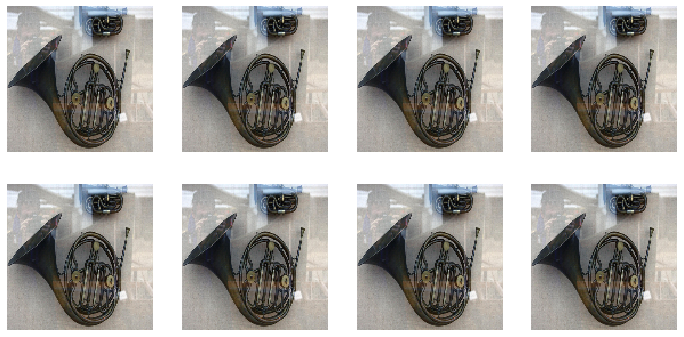

In [12]:
image_list_1.transforms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]
show_image_batch(next(iter(data_loader)))

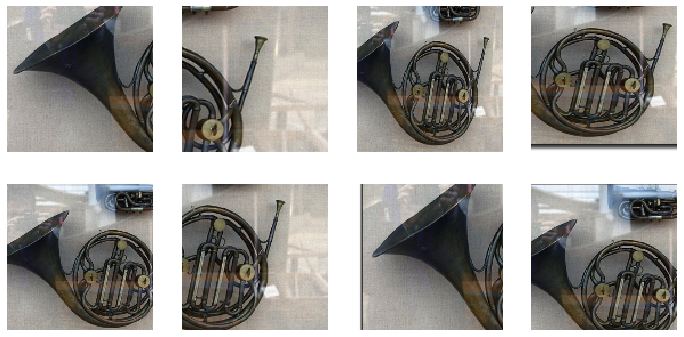

In [13]:
image_list_1.transforms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]
show_image_batch(next(iter(data_loader)))

## Perspective Warping

In [14]:
#export
from torch import FloatTensor
# https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/
 
def find_coeffs(src, tar):
    M = []
    for p1, p2 in zip(tar, src):
        M.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        M.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
    A = FloatTensor(M)
    B = FloatTensor(src).view(8, 1)
    return list(torch.solve(B, A)[0][:, 0])

def warp(img, size, src, resample=PIL.Image.BILINEAR):
    w, h = size
    tar = ((0,0), (0,h), (w,h), (w,0))
    coeffs = find_coeffs(src, tar)
    return img.transform(size, PIL.Image.PERSPECTIVE, list(coeffs), resample=resample)

def uniform(a, b):
    return a + (b-a)*random.random()

In [15]:
# export
class WarpRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.size = process_size(size)
        self.crop_size = None if crop_size is None else process_size(crop_size)
        self.magnitude = magnitude
        self.resample = resample
        
    def __call__(self, img):
        crop_size = default_crop_size(*img.size) if self.crop_size == None else self.crop_size
        left = randint(0, img.size[0] - crop_size[0])
        top  = randint(0, img.size[1] - crop_size[1])
        top_magn = min(self.magnitude, left/crop_size[0], (img.size[0]-left)/crop_size[0]-1)
        lr_magn  = min(self.magnitude, top /crop_size[1], (img.size[1]-top) /crop_size[1]-1)
        up_t = uniform(-top_magn, top_magn)
        lr_t = uniform(-lr_magn,  lr_magn)
        src = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src = src * tensor(crop_size).float() + tensor([left, top]).float()
        src = tuple([(int(c[0].item()), int(c[1].item())) for c in src])
        return warp(img, self.size, src, self.resample)

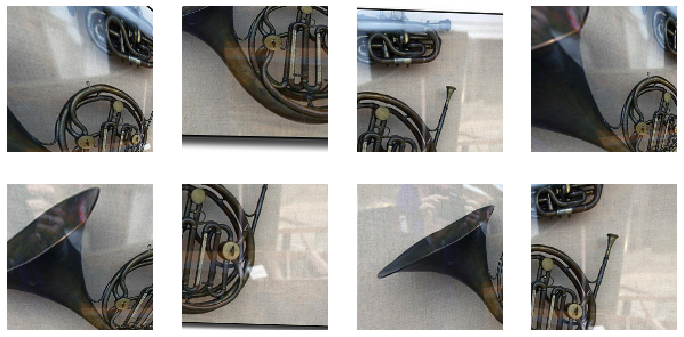

In [16]:
image_list_1.transforms = [make_rgb, WarpRandomCrop(128, 200, 0.2), to_byte_tensor, to_float_tensor]
show_image_batch(next(iter(data_loader)))